C:\Users\joelv\AppData\Local\Temp\ipykernel_20752\3236083117.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2020-10-19  112.815811  117.134673  112.504542  116.687224  120639300
2020-10-20  114.304070  115.733966  112.475355  113.029804  124423700
2020-10-21  113.681534  115.471331  113.272987  113.486986   89946000
2020-10-22  112.592079  114.819604  111.463723  114.245696  101988000
2020-10-23  111.901443  113.370249  111.162176  113.214611   82572600
Price            Close        High         Low        Open     Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL   
Date                                                                    
2020-12-29  131.416779  135.236409  130.900350  134.515365  121047300   
2020-12-30  130.296249  132.508133  129.984435  132.108627   96452100   
2020-12-31  129.292618  131.290133  128.347452  130.647028   99116600   
20

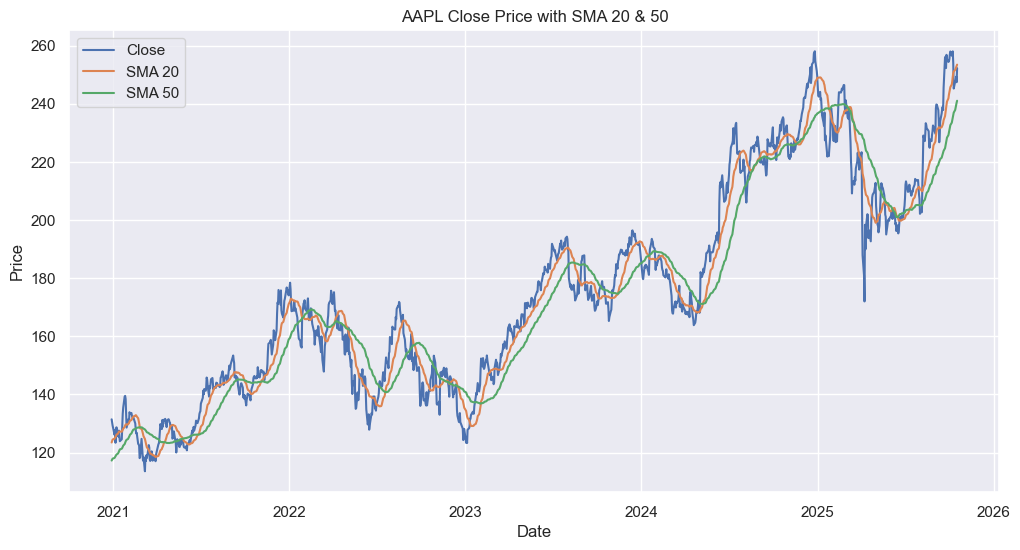

Linear Regression Performance:
MSE: 23.3440
RMSE: 4.8316
R²: 0.9328
XGBoost Performance:
MSE: 154.5003
RMSE: 12.4298
R²: 0.5555


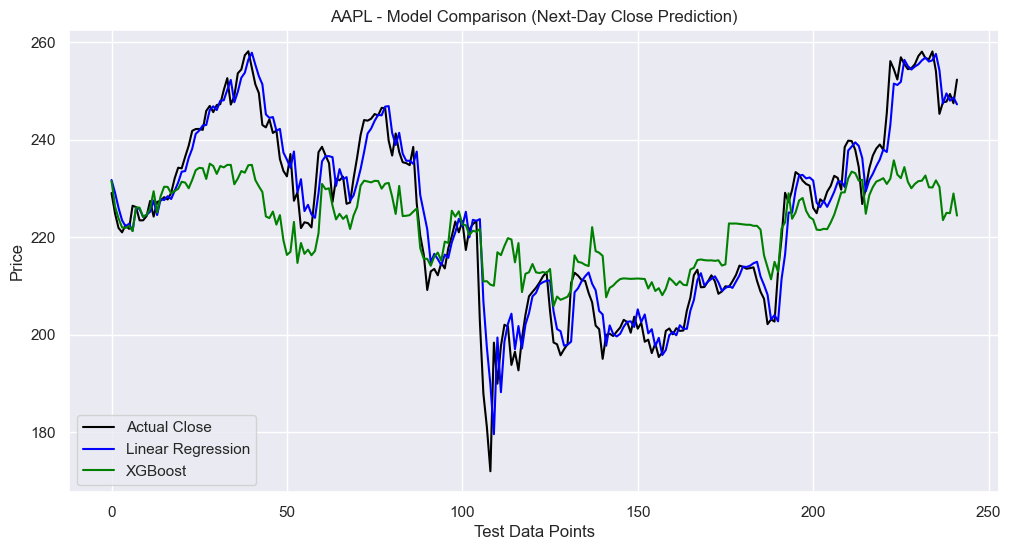

In [7]:
# ------------------------
# Step 1: Imports
# ------------------------
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ------------------------
# Step 2: Download stock data
# ------------------------
ticker = "AAPL"  # change ticker as needed
data = yf.download(ticker, period="5y", interval="1d")
df = data.copy()
print(df.head())

# ------------------------
# Step 3: Enhanced Technical Indicators + Features
# ------------------------
close_series = df["Close"].squeeze()

# Moving Averages
df["SMA_20"] = ta.trend.sma_indicator(close_series, window=20)
df["SMA_50"] = ta.trend.sma_indicator(close_series, window=50)
df["EMA_20"] = ta.trend.ema_indicator(close_series, window=20)
df["EMA_50"] = ta.trend.ema_indicator(close_series, window=50)

# Momentum Indicators
df["RSI_14"] = ta.momentum.rsi(close_series, window=14)
df["MACD"] = ta.trend.macd(close_series)
df["MACD_Signal"] = ta.trend.macd_signal(close_series)

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close_series, window=20, window_dev=2)
df["BB_High"] = bollinger.bollinger_hband()
df["BB_Low"] = bollinger.bollinger_lband()
df["BB_Width"] = df["BB_High"] - df["BB_Low"]

# Price & Volume Changes
df["Return_1D"] = df["Close"].pct_change()
df["Return_5D"] = df["Close"].pct_change(5)
df["Volume_Change"] = df["Volume"].pct_change()

# Drop NaN rows created by indicators
df.dropna(inplace=True)
print(df.head())

# ------------------------
# Step 4: Visualize Close Price with SMAs
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close')
plt.plot(df['SMA_20'], label='SMA 20')
plt.plot(df['SMA_50'], label='SMA 50')
plt.title(f"{ticker} Close Price with SMA 20 & 50")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# ------------------------
# Step 5: Prepare Features & Target
# ------------------------
df["Target"] = df["Close"].shift(-1)
df.dropna(inplace=True)

features = [
    "SMA_20", "SMA_50", "EMA_20", "EMA_50",
    "RSI_14", "MACD", "MACD_Signal",
    "BB_High", "BB_Low", "BB_Width",
    "Return_1D", "Return_5D", "Volume_Change"
]

X = df[features]
y = df["Target"]

# ------------------------
# Step 6: Train/Test Split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ------------------------
# Step 7: Linear Regression
# ------------------------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²: {r2_lr:.4f}")

# ------------------------
# Step 8: XGBoost
# ------------------------
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance:")
print(f"MSE: {mse_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")

# ------------------------
# Step 9: Compare Predictions
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Close", color="black")
plt.plot(y_pred_lr, label="Linear Regression", color="blue")
plt.plot(y_pred_xgb, label="XGBoost", color="green")
plt.title(f"{ticker} - Model Comparison (Next-Day Close Prediction)")
plt.xlabel("Test Data Points")
plt.ylabel("Price")
plt.legend()
plt.show()
